Calculate the Bayes Factor for the absolute magnitude to determine whether the void and wall samples are drawn from the same or different parent distributions.

In [1]:
from astropy.table import Table
from astropy.io import fits

import numpy as np

import sys

import pickle

import dynesty
from dynesty import plotting as dyplot

import matplotlib
import matplotlib.pyplot as plt

from functions import Model_1_plot, Model_2_plot, uniform, jeffreys#, Model_1_fit, Model_2_fit, Model_1_sampler, Model_2_sampler
from functions_gauss import Model_1_fit, Model_2_fit, Model_1_sampler, Model_2_sampler

np.set_printoptions(threshold=sys.maxsize)

In [2]:
#matplotlib.rcParams['text.usetex']=True
matplotlib.rc('font', size=14)
#matplotlib.rc('text', usetex=True)
matplotlib.rc('font', family='DejaVu Sans')

# Data

In [3]:
data_filename = '../../../../data/NSA_v1_0_1_VAGC_vflag-V2-VF.fits'

hdu = fits.open(data_filename)
data = Table(hdu[1].data)
hdu.close()

## Just keep the main SDSS DR7 footprint

In [4]:
# When the catalog is the NSA, only keep those objects which were originally in the DR7 LSS
catalog_SDSS = data[data['IN_DR7_LSS'] == 1]

ra_boolean = np.logical_and(catalog_SDSS['RA'] > 110, catalog_SDSS['RA'] < 270)
catalog_north = catalog_SDSS[ra_boolean]

strip_boolean = np.logical_and.reduce([catalog_north['RA'] > 250, 
                                       catalog_north['RA'] < 269, 
                                       catalog_north['DEC'] > 51, 
                                       catalog_north['DEC'] < 67])
catalog_main = catalog_north[~strip_boolean]

In [5]:
rabsmag_NSA = np.array(catalog_main['ELPETRO_ABSMAG'][:,4])

## Separate galaxies by their LSS classifications

### $V^2$

In [6]:
wall_v2 = catalog_main['vflag_V2'] == 0
void_v2 = catalog_main['vflag_V2'] == 1
edge_v2 = catalog_main['vflag_V2'] == 2
out_v2 = catalog_main['vflag_V2'] == 9

### VoidFinder

In [7]:
wall_vf = catalog_main['vflag_VF'] == 0
void_vf = catalog_main['vflag_VF'] == 1
edge_vf = catalog_main['vflag_VF'] == 2
out_vf = catalog_main['vflag_VF'] == 9

# Fit the distributions with skewnormal distributions

Both one- and two-parent models

## $M_r$

This is a unimodal distribution

### 1-parent model

In [8]:
rabsmag_fit_bounds1 = [[0.1, 10],     # s ...... Gaussian 1 to 2 scale factor
                       [1000, 20000], # a ...... Gaussian amplitude
                       [-22, -18],    # mu ..... Gaussian location
                       [0.1, 3],      # sigma .. Gaussian scale
                       [0, 5]]        # skew ... Gaussian skew

rabsmag_bins = np.linspace(-25, -12.5, 170)

V2_rabsmag_bestfit1 = Model_1_fit(rabsmag_fit_bounds1, 
                                  rabsmag_NSA[wall_v2], 
                                  rabsmag_NSA[void_v2], 
                                  rabsmag_bins, 
                                  1)

VF_rabsmag_bestfit1 = Model_1_fit(rabsmag_fit_bounds1, 
                                  rabsmag_NSA[wall_vf], 
                                  rabsmag_NSA[void_vf], 
                                  rabsmag_bins, 
                                  1)

running minimizer...this might take a few minutes...
running minimizer...this might take a few minutes...


In [9]:
V2_rabsmag_bestfit1

      fun: 5676480.116968622
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([-72.64316126,  -0.09313324, -65.00631033, -80.28000642,
        33.90014192])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 276
      nit: 33
     njev: 46
   status: 0
  success: True
        x: array([ 2.26766220e+00,  7.54926273e+03, -2.09542382e+01,  1.37336896e+00,
        2.12023067e+00])

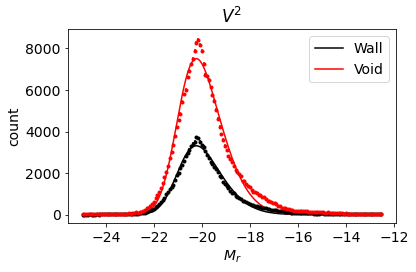

In [10]:
Model_1_plot(V2_rabsmag_bestfit1.x, 
             rabsmag_NSA[wall_v2], 
             rabsmag_NSA[void_v2], 
             rabsmag_bins, 
             1, 
             xlabel_text='$M_r$', 
             title_text='$V^2$')

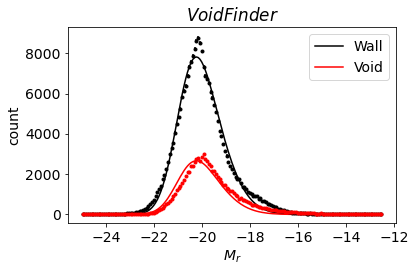

In [11]:
Model_1_plot(VF_rabsmag_bestfit1.x, 
             rabsmag_NSA[wall_vf], 
             rabsmag_NSA[void_vf], 
             rabsmag_bins, 
             1, 
             xlabel_text='$M_r$', 
             title_text='$VoidFinder$')

In [12]:
VF_rabsmag_bestfit1

      fun: 6966554.89398159
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([  1.30385161,  -0.18624955,   3.63215774, 120.97880318,
       -31.10617418])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 396
      nit: 33
     njev: 66
   status: 0
  success: True
        x: array([ 3.40801526e-01,  1.72810437e+04, -2.09186002e+01,  1.28062332e+00,
        1.83834716e+00])

#### Nested sampling of Likelihood and Priors

In [13]:
def prior_xform1_uni_V2(u):
    '''
    Priors for the 5 parameters of unimodel M1 for V2.  Required by 
    the dynesty sampler.  Note that this is customized for the 
    absolute magnitude fitting.


    PARAMETERS
    ==========

    u : ndarray
        Array of uniform random numbers between 0 and 1.


    RETURNS
    =======
    
    priors : ndarray
        Transformed random numbers giving prior ranges on model parameters.
    '''

    s = uniform(0.1, 5, u[0])
    a = jeffreys(1000, 10000, u[1])
    mu = uniform(-22, -18, u[2])
    sigma = uniform(0.01, 5, u[3])
    skew = uniform(0, 5, u[4])

    return s, a, mu, sigma, skew

In [14]:
Model_1_sampler(prior_xform1_uni_V2, 
                rabsmag_NSA[wall_v2], 
                rabsmag_NSA[void_v2], 
                rabsmag_bins, 
                1, 
                '_rabsmag_V2')

running the nested sampler... this might take from minutes to hours...


43587it [06:23, 113.70it/s, batch: 9 | bound: 140 | nc: 1 | ncall: 118998 | eff(%): 36.628 | loglstar: -5676487.452 <   -inf < -5676481.277 | logz:   -inf +/-  0.430 | stop:  0.814] 

sampler output saved as pickle file 'dynesty_output/sampler_results_model1_gauss_rabsmag_V2'


In [15]:
temp_infile = open('dynesty_output/sampler_results_model1_gauss_rabsmag_V2.pickle', 'rb')
dres1_V2_rabsmag = pickle.load(temp_infile)
temp_infile.close()

In [16]:
labels1_uni = ['s', 'a', r'$\mu$', r'$\sigma$', 'skew']
labels2_uni = ['a', r'$\mu_a$', r'$\sigma_a$', 'skew$_a$', 'b', r'$\mu_b$', r'$\sigma_b$', 'skew$_b$']

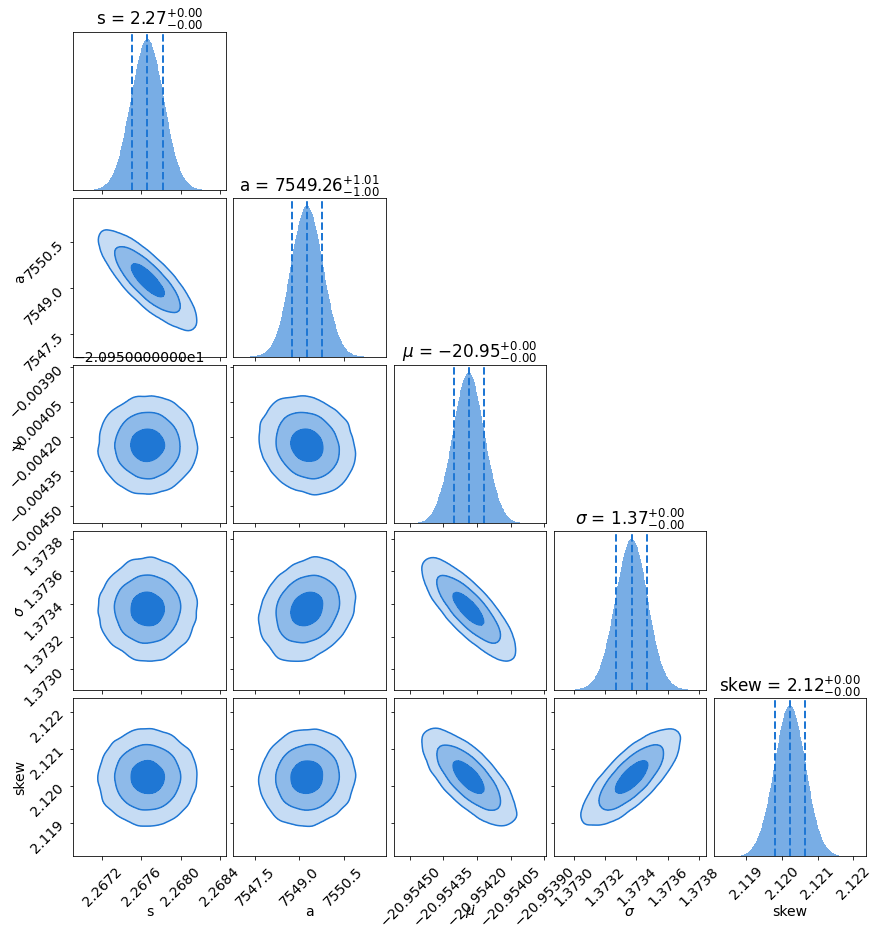

In [17]:
fig, axes = dyplot.cornerplot(dres1_V2_rabsmag, smooth=0.03, 
                              labels=labels1_uni, 
                              show_titles=True, 
                              quantiles_2d=[1-np.exp(-0.5*r**2) for r in [1, 2, 3]], 
                              quantiles=[0.16, 0.5, 0.84], 
                              fig=plt.subplots(5, 5, figsize=(2.5*5, 2.6*5)), 
                              color='#1f77d4')

In [18]:
lnzM1_V2_rabsmag = dres1_V2_rabsmag.logz[-1]
lnzM1_V2_rabsmag

-5676529.519143215

In [21]:
def prior_xform1_uni_VF(u):
    '''
    Priors for the 5 parameters of unimodel M1 for VoidFinder.  Required 
    by the dynesty sampler.  Note that this is customized for the 
    absolute magnitude fitting.


    PARAMETERS
    ==========

    u : ndarray
        Array of uniform random numbers between 0 and 1.


    RETURNS
    =======
    
    priors : ndarray
        Transformed random numbers giving prior ranges on model parameters.
    '''

    s = uniform(0.01, 5, u[0])
    a = jeffreys(1000, 50000, u[1])
    mu = uniform(-24, -18, u[2])
    sigma = uniform(0.01, 5, u[3])
    skew = uniform(0, 5, u[4])

    return s, a, mu, sigma, skew

In [22]:
Model_1_sampler(prior_xform1_uni_VF, 
                rabsmag_NSA[wall_vf], 
                rabsmag_NSA[void_vf], 
                rabsmag_bins, 
                1, 
                '_rabsmag_VoidFinder')

running the nested sampler... this might take from minutes to hours...


43209it [06:59, 102.89it/s, batch: 9 | bound: 143 | nc: 1 | ncall: 120287 | eff(%): 35.922 | loglstar: -6966562.143 <   -inf < -6966556.325 | logz:   -inf +/-  0.441 | stop:  0.975] 


sampler output saved as pickle file 'dynesty_output/sampler_results_model1_gauss_rabsmag_VoidFinder'


In [23]:
temp_infile = open('dynesty_output/sampler_results_model1_gauss_rabsmag_VoidFinder.pickle', 
                   'rb')
dres1_VF_rabsmag = pickle.load(temp_infile)
temp_infile.close()

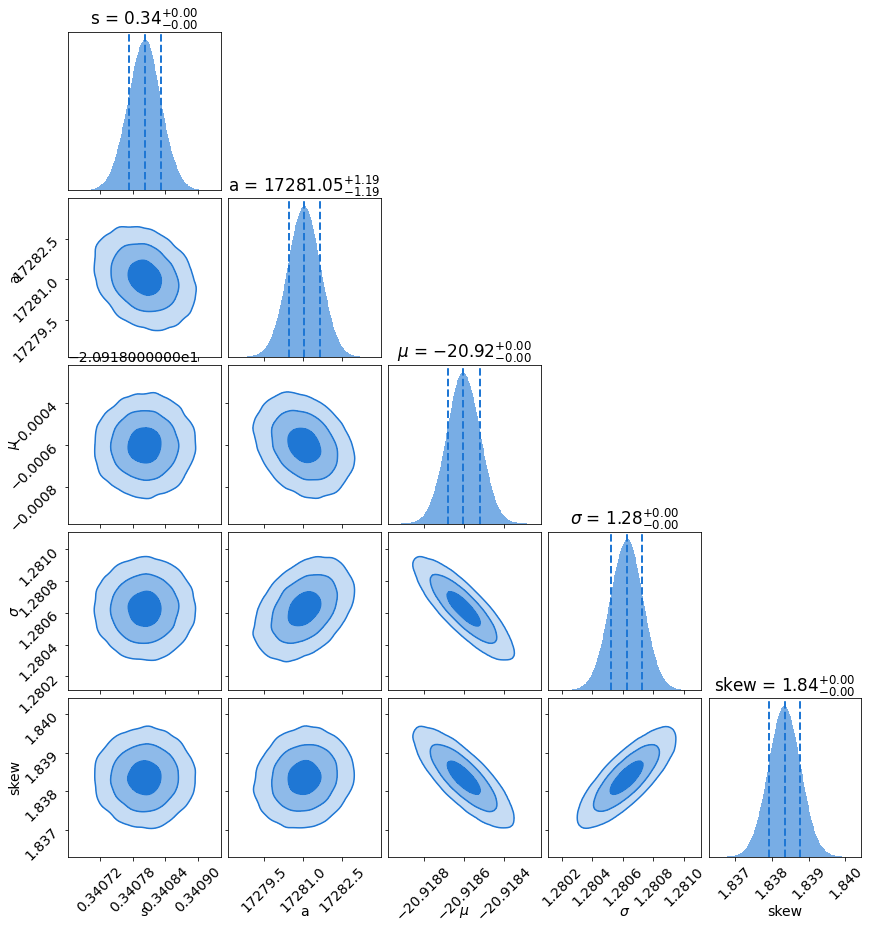

In [24]:
fig, axes = dyplot.cornerplot(dres1_VF_rabsmag, smooth=0.03, 
                              labels=labels1_uni, 
                              show_titles=True, 
                              quantiles_2d=[1-np.exp(-0.5*r**2) for r in [1, 2, 3]], 
                              quantiles=[0.16, 0.5, 0.84], 
                              fig=plt.subplots(5, 5, figsize=(2.5*5, 2.6*5)), 
                              color='#1f77d4')

In [25]:
lnzM1_VF_rabsmag = dres1_VF_rabsmag.logz[-1]
lnzM1_VF_rabsmag

-6966607.110886196

### 2-parent model

In [31]:
rabsmag_fit_bounds2 = [[500, 100000], # a ........ Gaussian A amplitude
                     [-25, -15],     # mu_a ..... Gaussian A location
                     [0.1, 5],       # sigma_a .. Gaussian A scale
                     [-5, 5],        # skew_a ... Gaussian A skew
                     [500, 100000],   # b ........ Gaussian B amplitude
                     [-25, -15],     # mu_b ..... Gaussian B location
                     [0.1, 3],       # sigma_b .. Gaussian B scale
                     [-5, 5]]        # skew_b ... Gaussian B skew

V2_rabsmag_bestfit2 = Model_2_fit(rabsmag_fit_bounds2, 
                                  rabsmag_NSA[wall_v2], 
                                  rabsmag_NSA[void_v2], 
                                  rabsmag_bins, 
                                  1)

VF_rabsmag_bestfit2 = Model_2_fit(rabsmag_fit_bounds2, 
                                  rabsmag_NSA[wall_vf], 
                                  rabsmag_NSA[void_vf], 
                                  rabsmag_bins, 
                                  1)

running minimizer...this might take a few minutes...
running minimizer...this might take a few minutes...


In [32]:
V2_rabsmag_bestfit2

      fun: 5636143.972591407
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
      jac: array([  0.        , 186.35763176, -34.8314645 ,  24.58691612,
         0.        , -15.27368896, 162.23639348, -27.56714838])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 774
      nit: 56
     njev: 86
   status: 0
  success: True
        x: array([ 7.50255148e+03, -2.09595541e+01,  1.34845618e+00,  2.07397994e+00,
        1.71403653e+04, -2.09531591e+01,  1.37825978e+00,  2.12940128e+00])

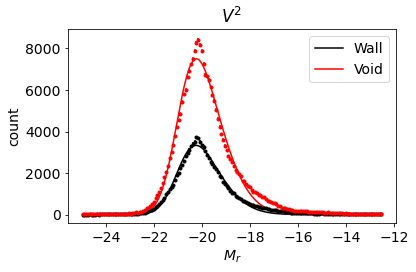

In [33]:
Model_2_plot(V2_rabsmag_bestfit2.x, 
             rabsmag_NSA[wall_v2], 
             rabsmag_NSA[void_v2], 
             rabsmag_bins, 
             1, 
             xlabel_text='$M_r$', 
             title_text='$V^2$')

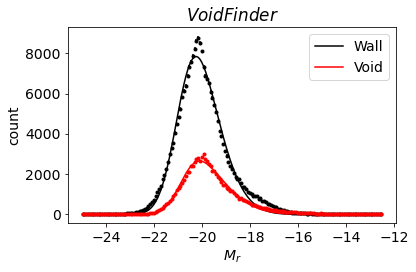

In [34]:
Model_2_plot(VF_rabsmag_bestfit2.x, 
             rabsmag_NSA[wall_vf], 
             rabsmag_NSA[void_vf], 
             rabsmag_bins, 
             1, 
             xlabel_text='$M_r$', 
             title_text='$VoidFinder$')

In [35]:
VF_rabsmag_bestfit2

      fun: 4876690.818794696
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.86249545e-01, -2.88709974e+02, -2.00793148e+02, -1.76951290e+01,
        9.31332424e-02,  7.74860318e+01,  1.45286323e+01, -6.05359677e+00])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 2664
      nit: 204
     njev: 296
   status: 0
  success: True
        x: array([ 1.72166753e+04, -2.09238015e+01,  1.25681967e+00,  1.76481983e+00,
        6.10638448e+03, -2.08252266e+01,  1.43860389e+00,  2.41437957e+00])

#### Nested sampling of Likelihood and Priors

In [36]:
def prior_xform2_uni_V2(u):
    '''
    Priors for the 8 parameters of unimodel M2.  Required by the dynesty 
    sampler.


    PARAMETERS
    ==========

    u : ndarray
        Array of uniform random numbers between 0 and 1.


    RETURNS
    =======
    
    priors : ndarray
        Transformed random numbers giving prior ranges on model parameters.
    '''

    a = jeffreys(1000, 10000, u[0])
    mu_a = uniform(-24, -18, u[1])
    sigma_a = uniform(0.1, 5, u[2])
    skew_a = uniform(0, 5, u[3])

    b = jeffreys(10000, 50000, u[4])
    mu_b = uniform(-24, -18, u[5])
    sigma_b = uniform(0.1, 5, u[6])
    skew_b = uniform(0, 5, u[7])

    return a, mu_a, sigma_a, skew_a, b, mu_b, sigma_b, skew_b

In [37]:
Model_2_sampler(prior_xform2_uni_V2, 
                rabsmag_NSA[wall_v2], 
                rabsmag_NSA[void_v2], 
                rabsmag_bins, 
                1, 
                '_rabsmag_V2')

running the nested sampler... this might take from minutes to hours...


56105it [10:27, 89.36it/s, batch: 8 | bound: 399 | nc: 5 | ncall: 331668 | eff(%): 16.916 | loglstar: -5636153.163 <   -inf < -5636147.128 | logz:   -inf +/-  0.526 | stop:  0.953]   


sampler output saved as pickle file 'dynesty_output/sampler_results_model2_gauss_rabsmag_V2'


In [38]:
temp_infile = open('dynesty_output/sampler_results_model2_gauss_rabsmag_V2.pickle', 'rb')
dres2_V2_rabsmag = pickle.load(temp_infile)
temp_infile.close()

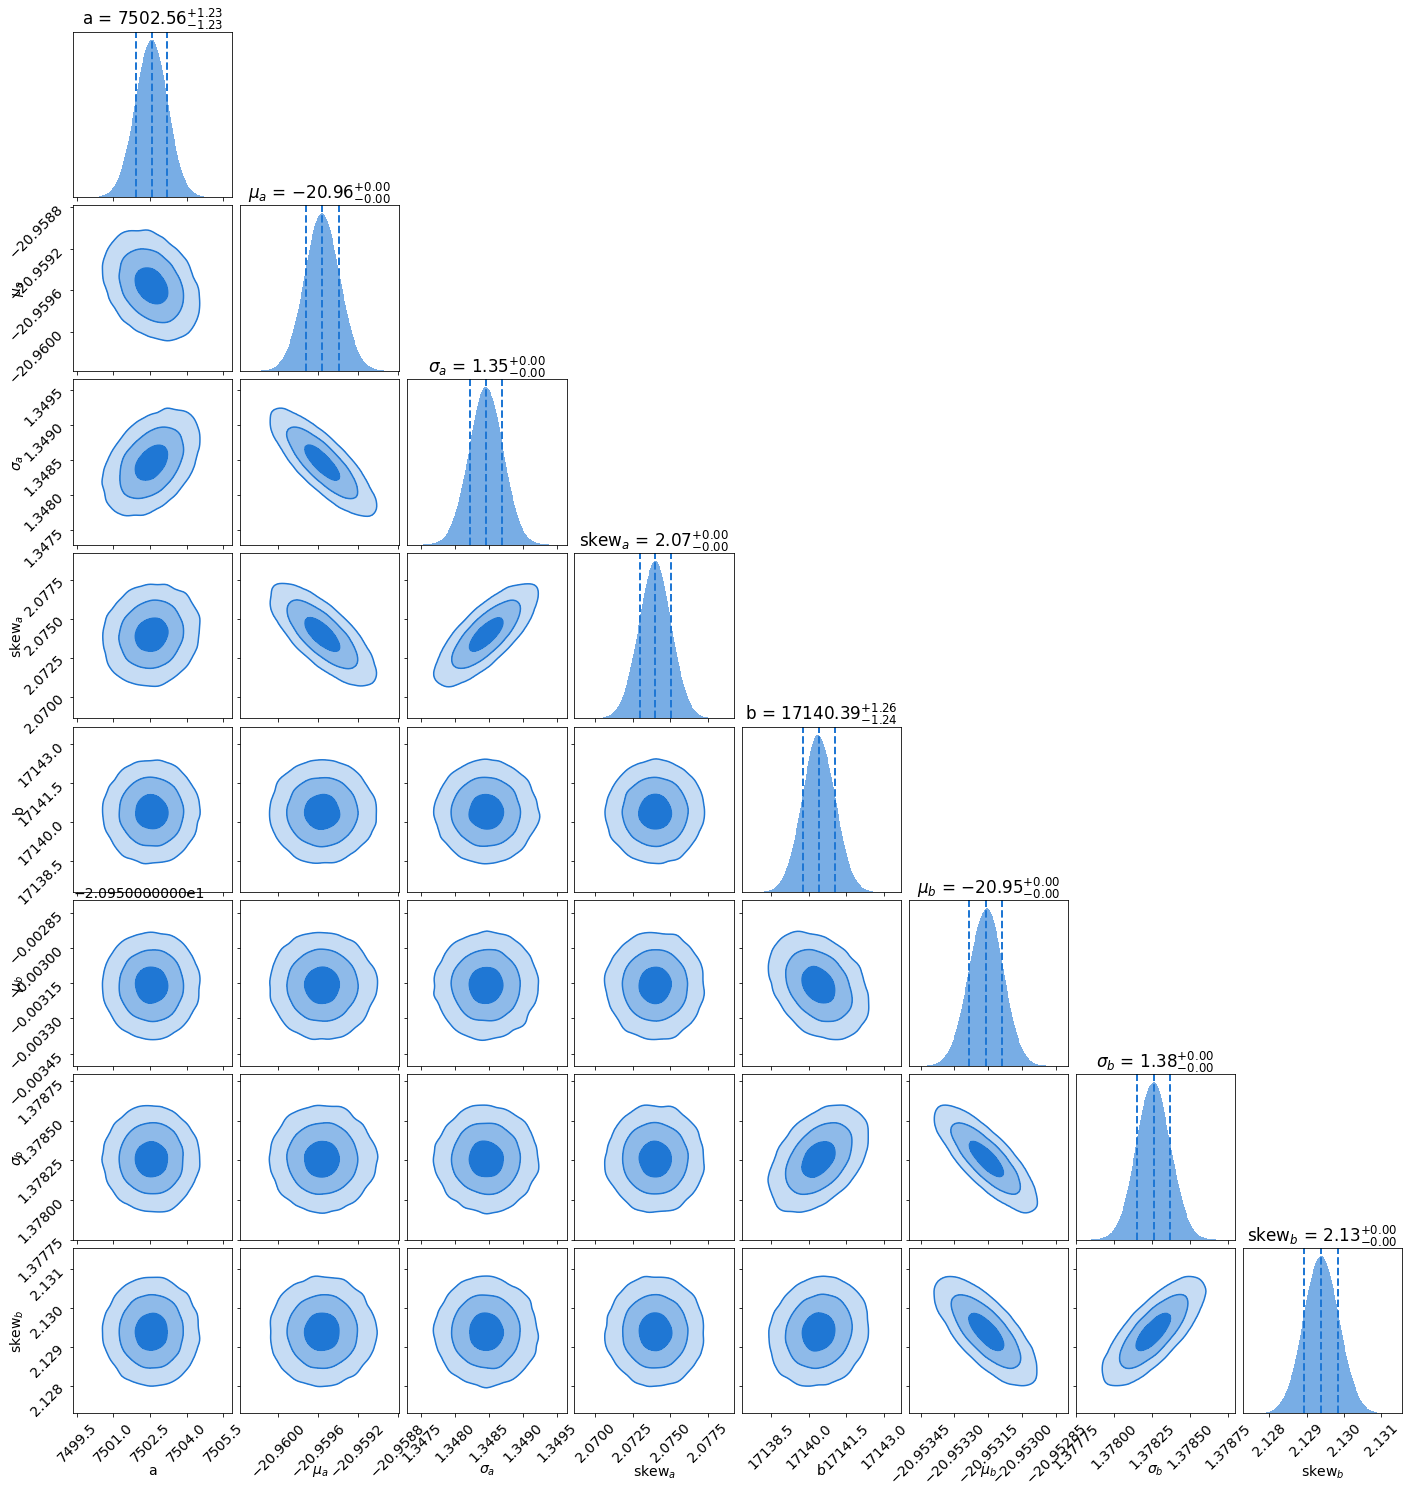

In [39]:
fig, axes = dyplot.cornerplot(dres2_V2_rabsmag, smooth=0.03, 
                              labels=labels2_uni, 
                              show_titles=True, 
                              quantiles_2d=[1-np.exp(-0.5*r**2) for r in [1, 2, 3]], 
                              quantiles=[0.16, 0.5, 0.84], 
                              fig=plt.subplots(8, 8, figsize=(2.5*8, 2.6*8)), 
                              color='#1f77d4')

In [40]:
lnzM2_V2_rabsmag = dres2_V2_rabsmag.logz[-1]
lnzM2_V2_rabsmag

-5636219.212958837

In [42]:
def prior_xform2_uni_VF(u):
    '''
    Priors for the 8 parameters of unimodel M2.  Required by the dynesty 
    sampler.


    PARAMETERS
    ==========

    u : ndarray
        Array of uniform random numbers between 0 and 1.


    RETURNS
    =======
    
    priors : ndarray
        Transformed random numbers giving prior ranges on model parameters.
    '''

    a = jeffreys(10000, 50000, u[0])
    mu_a = uniform(-24, -18, u[1])
    sigma_a = uniform(0.1, 5, u[2])
    skew_a = uniform(0, 5, u[3])

    b = jeffreys(500, 20000, u[4])
    mu_b = uniform(-24, -18, u[5])
    sigma_b = uniform(0.1, 5, u[6])
    skew_b = uniform(0, 5, u[7])

    return a, mu_a, sigma_a, skew_a, b, mu_b, sigma_b, skew_b

In [43]:
Model_2_sampler(prior_xform2_uni_VF, 
                rabsmag_NSA[wall_vf], 
                rabsmag_NSA[void_vf], 
                rabsmag_bins, 
                1, 
                '_rabsmag_VoidFinder')

running the nested sampler... this might take from minutes to hours...


53301it [09:47, 90.79it/s, batch: 7 | bound: 437 | nc: 7 | ncall: 362180 | eff(%): 14.717 | loglstar: -4876699.646 <   -inf < -4876692.499 | logz:   -inf +/-  0.526 | stop:  0.962]   


sampler output saved as pickle file 'dynesty_output/sampler_results_model2_gauss_rabsmag_VoidFinder'


In [44]:
temp_infile = open('dynesty_output/sampler_results_model2_GAUSS_rabsmag_VoidFinder.pickle', 
                   'rb')
dres2_VF_rabsmag = pickle.load(temp_infile)
temp_infile.close()

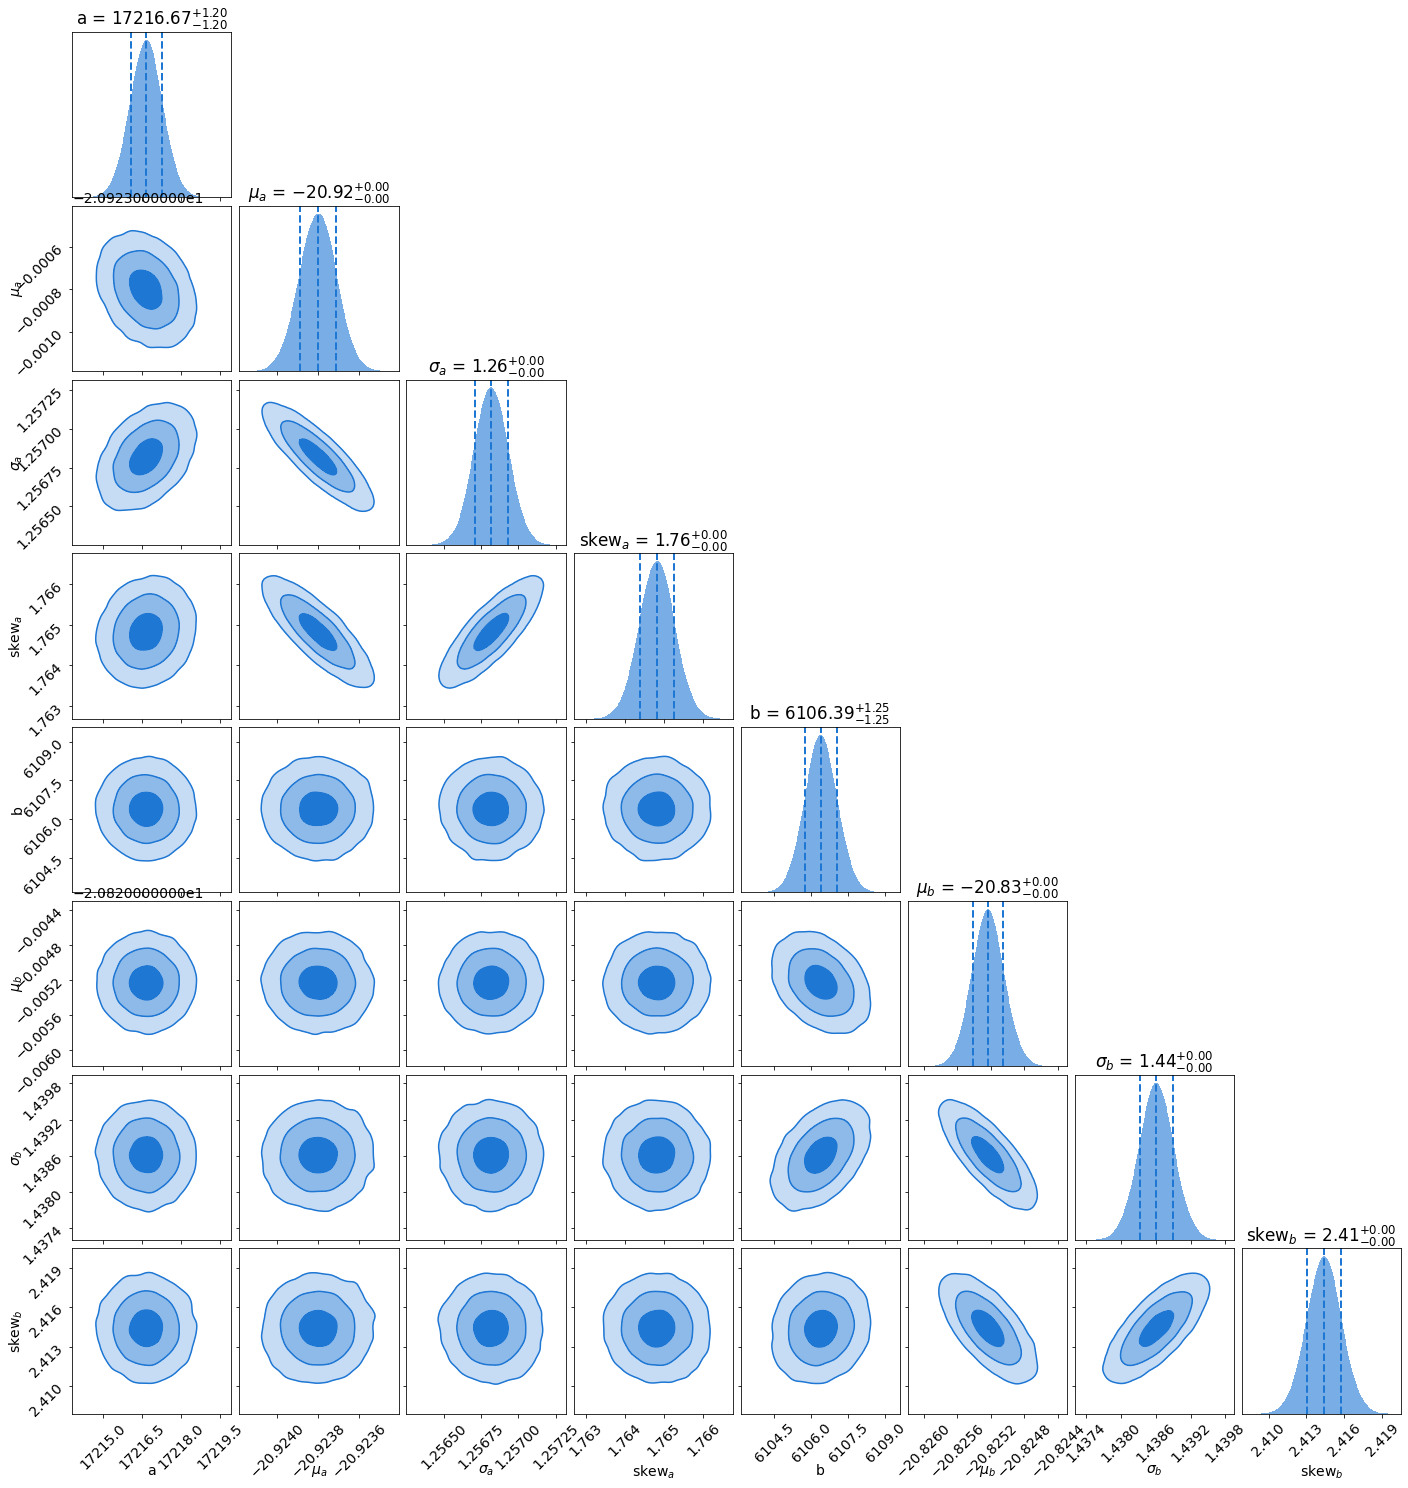

In [45]:
fig, axes = dyplot.cornerplot(dres2_VF_rabsmag, smooth=0.03, 
                              labels=labels2_uni, 
                              show_titles=True, 
                              quantiles_2d=[1-np.exp(-0.5*r**2) for r in [1, 2, 3]], 
                              quantiles=[0.16, 0.5, 0.84], 
                              fig=plt.subplots(8, 8, figsize=(2.5*8, 2.6*8)), 
                              color='#1f77d4')

In [46]:
lnzM2_VF_rabsmag = dres2_VF_rabsmag.logz[-1]
lnzM2_VF_rabsmag

-4876765.6141911885

## Bayes Factor

In [49]:
lnB12_V2_rabsmag = lnzM1_V2_rabsmag - lnzM2_V2_rabsmag

B12_V2_rabsmag = np.exp(lnB12_V2_rabsmag)

#print('V2 Mr: B12 = {:.3g}; log(B12) = {:.3g}'.format(B12_V2_rabsmag, np.log10(B12_V2_rabsmag)))
print('V2 Mr: B12 = {:.3g}; log(B12) = {:.3f}'.format(B12_V2_rabsmag, lnB12_V2_rabsmag*np.log10(np.exp(1))))

V2 Mr: B12 = 0; log(B12) = -17506.544


In [50]:
lnB12_VF_rabsmag = lnzM1_VF_rabsmag - lnzM2_VF_rabsmag

B12_VF_rabsmag = np.exp(lnB12_VF_rabsmag)

print('VoidFinder Mr: B12 = {:.3g}; log(B12) = {:.3f}'.format(B12_VF_rabsmag, 
                                                              lnB12_VF_rabsmag*np.log10(np.exp(1))))

VoidFinder Mr: B12 = 0; log(B12) = -907606.630


So both $V^2$ and VoidFinder overwhelmingly favor model $\mathcal{M}_2$, in which the two data sets come from different parent distributions.